In [ ]:
import os
import re
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import  Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

## Reading data

In [18]:
def load_imdb_data(data_dir):
    data = {'review': [], 'sentiment': [], 'split': []}
    for split in ['train', 'test']:
        for sentiment in ['pos', 'neg']:
            path = os.path.join(data_dir, split, sentiment)
            for fname in os.listdir(path):
                if fname.endswith(".txt"):
                    with open(os.path.join(path, fname), encoding='utf-8') as f:
                        data['review'].append(f.read())
                        data['sentiment'].append(1 if sentiment == 'pos' else 0)
                        data['split'].append(split)
    return pd.DataFrame(data)

# Read all data into dataframe
imdb_df = load_imdb_data('aclImdb')

# Save to csv for future usage
# imdb_df.to_csv("imdb_raws.csv", index=False)

imdb_df

,review,sentiment,split
0,Bromwell High is a cartoon comedy. It ran at t...,1,train
1,Homelessness (or Houselessness as George Carli...,1,train
2,Brilliant over-acting by Lesley Ann Warren. Be...,1,train
3,This is easily the most underrated film inn th...,1,train
4,This is not the typical Mel Brooks film. It wa...,1,train
...,...,...,...
49995,I occasionally let my kids watch this garbage ...,0,test
49996,When all we have anymore is pretty much realit...,0,test
49997,The basic genre is a thriller intercut with an...,0,test
49998,Four things intrigued me as to this film - fir...,0,test


In [32]:
imdb_df = pd.read_csv('imdb_raws.csv')
imdb_df

,review,sentiment,split
0,Bromwell High is a cartoon comedy. It ran at t...,1,train
1,Homelessness (or Houselessness as George Carli...,1,train
2,Brilliant over-acting by Lesley Ann Warren. Be...,1,train
3,This is easily the most underrated film inn th...,1,train
4,This is not the typical Mel Brooks film. It wa...,1,train
...,...,...,...
49995,I occasionally let my kids watch this garbage ...,0,test
49996,When all we have anymore is pretty much realit...,0,test
49997,The basic genre is a thriller intercut with an...,0,test
49998,Four things intrigued me as to this film - fir...,0,test


In [33]:
imdb_df_train = imdb_df[imdb_df['split'] == 'train'].copy()
imdb_df_test = imdb_df[imdb_df['split'] == 'test'].copy()
len(imdb_df_train), len(imdb_df_test)

(25000, 25000)

## Data Preprocessing

In [44]:
stop_words = set(stopwords.words('english'))

def clean_and_tokenize(text, remove_stopwords=False):
  # Replace HTML tags
  text = text.replace('<br />', ' ').replace('<br></br>', ' ')
    
  # Lowercase
  text = text.lower()
    
  # Remove non-alphabetic characters
  text = re.sub(r"[^a-zA-Z]", ' ', text)
    
  # Tokenize
  tokens = word_tokenize(text)
    
  # Remove stopwords
  if remove_stopwords:
    tokens = [t for t in tokens if t not in stop_words]
    
  return tokens

In [45]:
# Apply to DataFrame to add new column
imdb_df_train['tokens'] = imdb_df_train['review'].apply(lambda x: clean_and_tokenize(x, remove_stopwords=True))
imdb_df_train

,review,sentiment,split,tokens
0,Bromwell High is a cartoon comedy. It ran at t...,1,train,"[bromwell, high, cartoon, comedy, ran, time, p..."
1,Homelessness (or Houselessness as George Carli...,1,train,"[homelessness, houselessness, george, carlin, ..."
2,Brilliant over-acting by Lesley Ann Warren. Be...,1,train,"[brilliant, acting, lesley, ann, warren, best,..."
3,This is easily the most underrated film inn th...,1,train,"[easily, underrated, film, inn, brooks, cannon..."
4,This is not the typical Mel Brooks film. It wa...,1,train,"[typical, mel, brooks, film, much, less, slaps..."
...,...,...,...,...
24995,"Towards the end of the movie, I felt it was to...",0,train,"[towards, end, movie, felt, technical, felt, l..."
24996,This is the kind of movie that my enemies cont...,0,train,"[kind, movie, enemies, content, watch, time, b..."
24997,I saw 'Descent' last night at the Stockholm Fi...,0,train,"[saw, descent, last, night, stockholm, film, f..."
24998,Some films that you pick up for a pound turn o...,0,train,"[films, pick, pound, turn, rather, good, rd, c..."


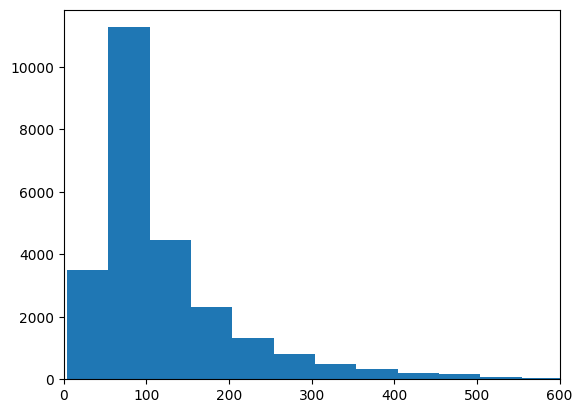

In [61]:
# Plot histogram to see review length distribution
review_length_train = imdb_df_train['tokens'].apply(lambda x: len(x))

bin_width = 50
bins_train = np.arange(min(review_length_train), max(review_length_train) + bin_width, bin_width)

plt.hist(review_length_train, bins=bins_train)
plt.xlim(0, 600)
plt.show()

In [72]:
review_length_train.describe()

count    25000.000000
mean       119.512800
std         90.566264
min          4.000000
25%         63.000000
50%         89.000000
75%        146.000000
max       1422.000000
Name: tokens, dtype: float64

In [46]:
# Apply to DataFrame to add new column
imdb_df_test['tokens'] = imdb_df_test['review'].apply(lambda x: clean_and_tokenize(x, remove_stopwords=True))
imdb_df_test

,review,sentiment,split,tokens
25000,I went and saw this movie last night after bei...,1,test,"[went, saw, movie, last, night, coaxed, friend..."
25001,Actor turned director Bill Paxton follows up h...,1,test,"[actor, turned, director, bill, paxton, follow..."
25002,As a recreational golfer with some knowledge o...,1,test,"[recreational, golfer, knowledge, sport, histo..."
25003,"I saw this film in a sneak preview, and it is ...",1,test,"[saw, film, sneak, preview, delightful, cinema..."
25004,Bill Paxton has taken the true story of the 19...,1,test,"[bill, paxton, taken, true, story, us, golf, o..."
...,...,...,...,...
49995,I occasionally let my kids watch this garbage ...,0,test,"[occasionally, let, kids, watch, garbage, unde..."
49996,When all we have anymore is pretty much realit...,0,test,"[anymore, pretty, much, reality, tv, shows, pe..."
49997,The basic genre is a thriller intercut with an...,0,test,"[basic, genre, thriller, intercut, uncomfortab..."
49998,Four things intrigued me as to this film - fir...,0,test,"[four, things, intrigued, film, firstly, stars..."


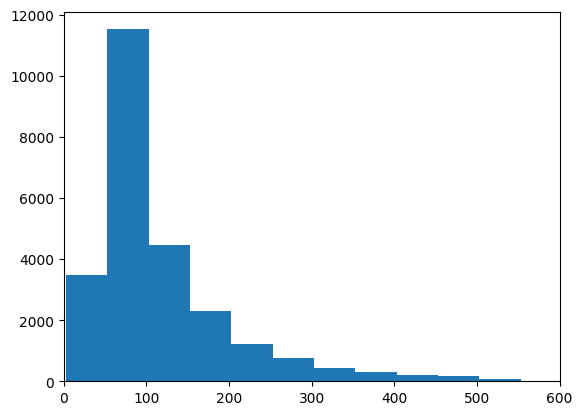

In [77]:
# Plot histogram to see review length distribution
review_length_test = imdb_df_test['tokens'].apply(lambda x: len(x))

bin_width = 50
bins_test = np.arange(min(review_length_test), max(review_length_test) + bin_width, bin_width)

plt.hist(review_length_test, bins=bins_test)
plt.xlim(0, 600)
plt.show()

In [73]:
review_length_test.describe()

count    25000.000000
mean       116.752320
std         88.181541
min          3.000000
25%         63.000000
50%         87.000000
75%        142.000000
max       1154.000000
Name: tokens, dtype: float64

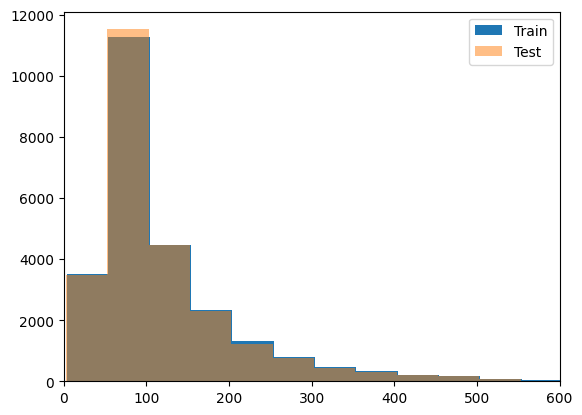

In [74]:
# Plot both histogram to see their difference
plt.hist(review_length_train, bins=bins_train, label="Train")
plt.hist(review_length_test, bins=bins_test, alpha=0.5, label="Test")
plt.xlim(0, 600)
plt.legend()
plt.show()

## Vocabulary

In [548]:
class Vocabulary:
  def __init__(self, token_to_index={}, pad_token='<pad>', unk_token='<unk>'):
    self.token_to_index = token_to_index

    if len(self.token_to_index) == 0:
      self.token_to_index[pad_token] = 0
      self.token_to_index[unk_token] = 1

    self.index_to_token = {index: token for token, index in self.token_to_index.items()}

    self.pad_token = pad_token
    self.pad_index = self.token_to_index[self.pad_token]

    self.unk_token = unk_token
    self.unk_index = self.token_to_index[self.unk_token]
  
  def __len__(self):
    return len(self.token_to_index)

  def add_token(self, token):
    if token in self.token_to_index:
      index = self.token_to_index[token]
    else:
      index = len(self.token_to_index)
      self.token_to_index[token] = index
      self.index_to_token[index] = token
    return index

  def lookup_token(self, token):
    return self.token_to_index.get(token, self.unk_index)
  
  def lookup_index(self, index):
    if index not in self.index_to_token:
      raise KeyError(f"the index {index} is not in the Vocabulary")
    return self.index_to_token[index]

  # Build vocab from tokenized data filtered by minimun frequency of each word
  @classmethod
  def build_vocab_with_min_freq(cls, token_lists, min_freq=25):
    counter = Counter()
    for tokens in token_lists:
      counter.update(tokens)
    
    # '<pad>' is for padding review to have the same length
    # '<unk>' is for unknown word that are removed or not in train data
    vocab = {'<pad>': 0, '<unk>': 1}
    
    for word, freq in counter.items():
      if freq >= min_freq:
        vocab[word] = len(vocab)
    
    return cls(vocab)

  # Build vocab from tokenized data filtered by maximun words in vocab
  @classmethod
  def build_vocab_with_max_words(cls, token_lists, max_words=8000):
    counter = Counter()
    for tokens in token_lists:
      counter.update(tokens)
    
    # '<pad>' is for padding review to have the same length
    # '<unk>' is for unknown word that are removed or not in train data
    vocab = {'<pad>': 0, '<unk>': 1}
  
    most_common_words = counter.most_common(max_words - 2)
    for word, _ in most_common_words:
      vocab[word] = len(vocab)

    return cls(vocab)

In [549]:
# Build vocabulary from train data
review_vocab = Vocabulary.build_vocab_with_max_words(imdb_df_train['tokens'])
len(review_vocab)

8000

## Vectorizer

In [ ]:
class Vectorizer:
  def __init__(self, vocab: Vocabulary):
    self.vocab = vocab
    self.vocab_size = len(vocab)

  # Turn token into index for embedding
  def index_vectorize(self, token_list):
    indices = np.zeros(len(token_list), dtype=np.float32)
    for i, token in enumerate(token_list):
      index = self.vocab.lookup_token(token)
      indices[i] = index
    return indices

  # One-Hot encoder for Feedforward Neural Network
  def onehot_vectorize(self, token_list):
    onehot = np.zeros(self.vocab_size, dtype=np.float32)
    for token in token_list:
      index = self.vocab.lookup_token(token)
      onehot[index] += 1.0
    return onehot

In [598]:
review_vectorizer = Vectorizer(review_vocab)

In [ ]:
# See example of index vectorize
review_vectorizer.index_vectorize(imdb_df_train['tokens'][0])

array([1.000e+00, 1.940e+02, 9.150e+02, 1.020e+02, 1.994e+03, 7.000e+00,
       5.643e+03, 2.640e+02, 3.400e+01, 5.050e+03, 5.900e+01, 4.829e+03,
       5.707e+03, 3.540e+02, 1.480e+02, 1.000e+00, 1.940e+02, 1.839e+03,
       1.400e+01, 2.254e+03, 4.850e+02, 5.050e+03, 1.000e+00, 1.844e+03,
       1.000e+00, 5.644e+03, 1.363e+03, 1.200e+01, 9.900e+01, 1.066e+03,
       5.050e+03, 1.000e+00, 1.000e+00, 1.150e+02, 7.510e+02, 2.848e+03,
       5.645e+03, 5.580e+02, 1.363e+03, 1.100e+02, 2.650e+02, 1.275e+03,
       3.544e+03, 6.520e+02, 3.344e+03, 2.640e+02, 1.079e+03, 1.000e+00,
       1.940e+02, 2.330e+02, 2.250e+02, 2.772e+03, 7.543e+03, 4.000e+00,
       5.050e+03, 1.275e+03, 2.185e+03, 1.000e+00, 1.940e+02, 4.040e+02,
       3.300e+01, 1.314e+03, 4.180e+02, 2.600e+01, 1.000e+00, 1.940e+02,
       1.200e+02, 4.001e+03, 2.072e+03], dtype=float32)

In [ ]:
# See example of one hot vectorize
onehot = review_vectorizer.onehot_vectorize(imdb_df_train['tokens'][0])
onehot, list(filter(lambda x: x[-1] > 0, [(review_vocab.lookup_index(index), index, freq) for index, freq in enumerate(onehot)]))

(array([0., 9., 0., ..., 0., 0., 0.], dtype=float32),
 [('<unk>', 1, np.float32(9.0)),
  ('one', 4, np.float32(1.0)),
  ('time', 7, np.float32(1.0)),
  ('see', 12, np.float32(1.0)),
  ('much', 14, np.float32(1.0)),
  ('think', 26, np.float32(1.0)),
  ('many', 33, np.float32(1.0)),
  ('life', 34, np.float32(1.0)),
  ('years', 59, np.float32(1.0)),
  ('right', 99, np.float32(1.0)),
  ('comedy', 102, np.float32(1.0)),
  ('saw', 110, np.float32(1.0)),
  ('whole', 115, np.float32(1.0)),
  ('far', 120, np.float32(1.0)),
  ('believe', 148, np.float32(1.0)),
  ('high', 194, np.float32(5.0)),
  ('line', 225, np.float32(1.0)),
  ('classic', 233, np.float32(1.0)),
  ('school', 264, np.float32(2.0)),
  ('episode', 265, np.float32(1.0)),
  ('lead', 354, np.float32(1.0)),
  ('expect', 404, np.float32(1.0)),
  ('age', 418, np.float32(1.0)),
  ('reality', 485, np.float32(1.0)),
  ('knew', 558, np.float32(1.0)),
  ('tried', 652, np.float32(1.0)),
  ('situation', 751, np.float32(1.0)),
  ('cartoon', 915

## Dataset

In [617]:
class IndexReviewDataset(Dataset):
  def __init__(self, imdb_df, vectorizer: Vectorizer, max_length):
    self.review_df = imdb_df
    self.vectorizer = vectorizer
    self.max_length = max_length
    self.pad_index = vectorizer.vocab.pad_index

  def __len__(self):
    return len(self.review_df)

  def __getitem__(self, index):
    row = self.review_df.iloc[index]
    review_indices = self.vectorizer.index_vectorize(row.tokens[:self.max_length])
    padded = np.full(self.max_length, fill_value=self.pad_index)
    padded[:len(review_indices)] = review_indices
    sentiment_vector = row.sentiment
    return {'x': padded,
            'y': sentiment_vector}

  def get_vectorizer(self):
    return self.vectorizer 
  
  def get_num_batches(self, batch_size):
    return len(self) // batch_size 

In [623]:
index_dataset_train = IndexReviewDataset(imdb_df=imdb_df_train, vectorizer=review_vectorizer, max_length=300)

In [606]:
class OneHotReviewDataset(Dataset):
  def __init__(self, imdb_df, vectorizer: Vectorizer):
    self.review_df = imdb_df
    self.vectorizer = vectorizer

  def __len__(self):
    return len(self.review_df)

  def __getitem__(self, index):
    row = self.review_df.iloc[index]
    review_vector = self.vectorizer.onehot_vectorize(row.tokens)
    sentiment_vector = row.sentiment
    return {'x': review_vector,
            'y': sentiment_vector}

  def get_vectorizer(self):
    return self.vectorizer 
  
  def get_num_batches(self, batch_size):
    return len(self) // batch_size 

In [624]:
onehot_dataset_train = OneHotReviewDataset(imdb_df=imdb_df_train, vectorizer=review_vectorizer)

## Dataloader

In [610]:
def generate_batches(dataset, batch_size, 
                     shuffle=True,
                     drop_last=True, 
                     device="cpu"):
  
  dataloader = DataLoader(dataset=dataset, 
                          batch_size=batch_size,
                          shuffle=shuffle, 
                          drop_last=drop_last)

  for data_dict in dataloader:
    out_data_dict = {}
    for name, tensor in data_dict.items():
      out_data_dict[name] = data_dict[name].to(device)
    yield out_data_dict

In [625]:
# Using generate_batches to get 1 sample at a time
for out_dict in generate_batches(dataset=index_dataset_train, batch_size=32):
  x_data = out_dict['x']
  y_target = out_dict['y']
  print(f"x shape: {x_data.shape}, y shape: {y_target.shape}")
  print(x_data)
  print(y_target)
  break

x shape: torch.Size([32, 300]), y shape: torch.Size([32])
tensor([[   1, 1594,    1,  ...,    0,    0,    0],
        [ 483,    2,   66,  ...,    0,    0,    0],
        [1192,    4, 1659,  ..., 2796, 5581,  439],
        ...,
        [1270, 7593,   40,  ...,    0,    0,    0],
        [  93,    4, 2107,  ...,    0,    0,    0],
        [ 138,    2,   32,  ...,    0,    0,    0]])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 1, 1, 0, 0])


In [626]:
# Using generate_batches to get 1 sample at a time
for out_dict in generate_batches(dataset=onehot_dataset_train, batch_size=32):
  x_data = out_dict['x']
  y_target = out_dict['y']
  print(f"x shape: {x_data.shape}, y shape: {y_target.shape}")
  print(x_data)
  print(y_target)
  break

x shape: torch.Size([32, 8000]), y shape: torch.Size([32])
tensor([[ 0., 10.,  1.,  ...,  0.,  0.,  0.],
        [ 0., 12.,  0.,  ...,  0.,  0.,  0.],
        [ 0., 21.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0., 13.,  3.,  ...,  0.,  0.,  0.],
        [ 0.,  4.,  0.,  ...,  0.,  0.,  0.],
        [ 0., 10.,  0.,  ...,  0.,  0.,  0.]])
tensor([1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 0, 1, 1, 1])


## Model